In [1]:
%cd ..

/home/jovyan/work/spectrum/c_final/v1


In [2]:
import pandas as pd
import base
import os
import pickle
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping 
from keras.models import load_model

from datetime import datetime

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.manifold import TSNE
import seaborn as sns

2024-02-27 09:18:18.945013: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 09:18:18.979717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 09:18:18.979759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 09:18:18.980613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 09:18:18.986479: I tensorflow/core/platform/cpu_feature_guar

In [3]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

SMとPCを区別する

In [4]:
df_pos = pd.read_csv('Data/02_basedata/pos/df_pos.csv' )
df_pos2x = df_pos[df_pos['Ontology'].isin(['PC','SM'])]

In [5]:
base.create_mspfile_fromdf(df_pos2x, 'PC-SM_posdata', ionmode = 'Positive')

/tmp/ipykernel_1008256/1600976726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos2x['modnum'] = base.cal_mod(df_pos2x['AverageMz'])


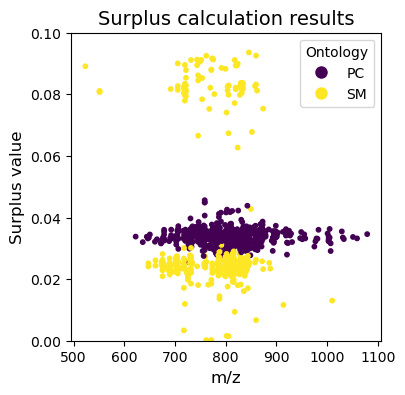

In [6]:
df_pos2x['modnum'] = base.cal_mod(df_pos2x['AverageMz'])

df_posx = df_pos2x[df_pos2x['Ontology'].isin(['SM','PC'])] #,'EtherLPC','LPC'])]
df_posx['Ontology'] = df_posx['Ontology'].astype(str)

fig, ax = plt.subplots(1,1,figsize=(4,4))

df_posx['OntologyCode'] = pd.Categorical(df_posx['Ontology']).codes
scatter = plt.scatter(df_posx['AverageMz'], df_posx['modnum'], c=df_posx['OntologyCode'], cmap='viridis', s=10)

plt.xlabel('m/z', fontsize=12)
plt.ylabel('Surplus value', fontsize=12)
plt.title('Surplus calculation results', fontsize=14)

plt.ylim(0, 0.1)

legend_labels = df_posx['Ontology'].unique()
legend_labels_numeric = df_posx['Ontology'].astype('category').cat.codes.unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in legend_labels_numeric]
plt.legend(legend_handles, legend_labels, title='Ontology', loc='upper right')

#plt.savefig('Data/svg/model/result/pos/rowvalue_o-value_pc-sm_dist.svg', format='svg', bbox_inches='tight')

PCのスペクトル

In [17]:
df_pos_exp_ = base.spectrum_tidy(df_posx)
df_pos_neuloss_ = base.neutralloss_tidy(df_posx)
df_pos_data = base.spectrum_neutralloss_table(df_pos_exp_, df_pos_neuloss_)

In [20]:
df_pos_data_posint = df_pos_data.drop(columns=['AverageMz', 'AlignmentID','Metabolitename', 'Ontology','dataset'])
df_pos_data_posint = pd.DataFrame(df_pos_data_posint.T).reset_index().astype(float).query('index > 0').set_index('index').T

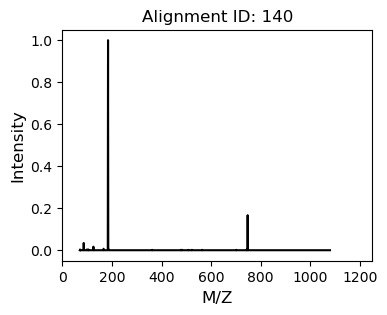

In [21]:
Alignmnentid = 140
df1= pd.DataFrame(df_pos_data_posint.iloc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/pos/data_id140_PC.svg', format='svg', bbox_inches='tight')

plt.show()

PEのスペクトル

In [28]:
df_posx = df_pos[df_pos['Ontology'].isin(['PE'])]

df_pos_exp_ = base.spectrum_tidy(df_posx)
df_pos_neuloss_ = base.neutralloss_tidy(df_posx)
df_pos_data = base.spectrum_neutralloss_table(df_pos_exp_, df_pos_neuloss_)

df_pos_data_posint = df_pos_data.drop(columns=['AverageMz', 'AlignmentID','Metabolitename', 'Ontology','dataset'])
df_pos_data_posint = pd.DataFrame(df_pos_data_posint.T).reset_index().astype(float).query('index > 0').set_index('index').T

(0.0, 1250.0)

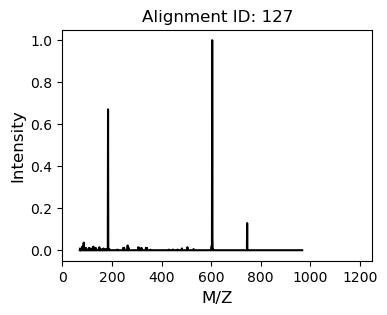

In [33]:
Alignmnentid = 127
df1= pd.DataFrame(df_pos_data_posint.iloc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

In [8]:
Alignmnentid = 32396
df = df_posx[df_posx['Unnamed: 0'] == Alignmnentid]
base.create_mspfile_fromdf(df, title= 'Spectrum_s1c_PC331_pos', ionmode = 'Positive')

SMのスペクトル

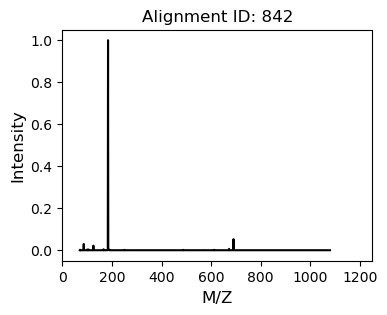

In [42]:
Alignmnentid = 842
df1= pd.DataFrame(df_pos_data_posint.iloc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/pos/data_id842_sm.svg', format='svg', bbox_inches='tight')

plt.show()

In [9]:
Alignmnentid = 5486
df = df_posx[df_posx['Unnamed: 0'] == Alignmnentid]
base.create_mspfile_fromdf(df, title= 'Spectrum_s1c_SM3312O_pos', ionmode = 'Positive')

___

In [102]:
df_pos = pd.read_csv('Data/02_basedata/pos/df_pos.csv' )
df_pos['modnum'] = base.cal_mod(df_pos['AverageMz'])

df_posx = df_pos[df_pos['Ontology'].isin(['EtherPC','PC'])] #,'EtherLPC','LPC'])]
df_posx['Ontology'] = df_posx['Ontology'].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_639069/1566469488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posx['OntologyCode'] = pd.Categorical(df_posx['Ontology']).codes


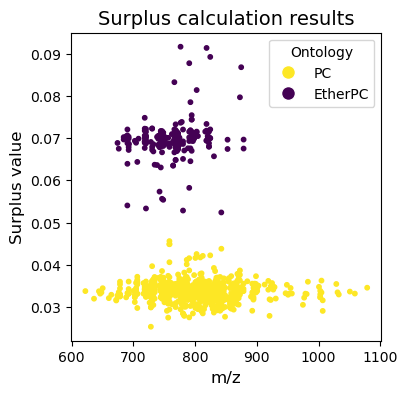

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

df_posx['OntologyCode'] = pd.Categorical(df_posx['Ontology']).codes
scatter = plt.scatter(df_posx['AverageMz'], df_posx['modnum'], c=df_posx['OntologyCode'], cmap='viridis', s=10)

plt.xlabel('m/z', fontsize=12)
plt.ylabel('Surplus value', fontsize=12)
plt.title('Surplus calculation results', fontsize=14)

legend_labels = df_posx['Ontology'].unique()
legend_labels_numeric = df_posx['Ontology'].astype('category').cat.codes.unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in legend_labels_numeric]
plt.legend(legend_handles, legend_labels, title='Ontology', loc='upper right')

テーブルデータの作成

In [5]:
df_pos_data = pd.read_csv('Data/02_basedata/pos/df_pos_data_.csv').query('Ontology not in ["NAE","Others"]')
ontlist = pd.DataFrame(df_pos_data.Ontology.value_counts()).reset_index().query('count >= 4').Ontology.tolist()
df_pos_data2 = df_pos_data[df_pos_data['Ontology'].isin(ontlist)].reset_index(drop=True).reset_index(drop=True)

In [6]:
df_pos = pd.read_csv('Data/02_basedata/pos/df_pos.csv' )

df_pos['div2'] = df_pos['AverageMz'].round().astype(int) % 2
df_pos['modnum'] = base.cal_mod(df_pos['AverageMz'])

In [7]:
df_pos_data2x = df_pos_data2.merge(df_pos[['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz','div2','modnum']], how='left',\
    on=['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz'])
df_pos_data2x.to_csv('Data/02_basedata/pos/pos2.csv', index=False)

In [8]:
## train/test/eval
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_pos_data2x.drop(columns=columns_to_drop).astype(float).values
y = df_pos_data2x['Ontology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
train_d, test_d = train_test_split(df_pos_data2x, test_size=0.2, random_state=42)

columnslist = df_pos_data2x.drop(columns=columns_to_drop).columns
with open('Data/03_model/pos/posmodelcolumn_all.pkl', 'wb') as file:
    pickle.dump(columnslist, file)
    
replacement_dict = base.replacement_dict_mapping(df_pos_data2x.Ontology.drop_duplicates().tolist())

with open('Data/03_model/pos/pos_replacement_dict_all.pkl', 'wb') as file:
    pickle.dump(replacement_dict, file)

y_test.to_csv('Data/04_canopus/pos/df_pos_ytest.csv')

　NN

In [10]:
# データの前処理：ラベルの置換
y_train_replaced0 = y_train.replace(replacement_dict).to_numpy().astype('int64')
y_test_replaced0 = y_test.replace(replacement_dict).to_numpy().astype('int64')
y_eval_replaced0 = y_eval.replace(replacement_dict).to_numpy().astype('int64')

y_train_onehot = to_categorical(y_train_replaced0, len(ontlist))
y_test_onehot = to_categorical(y_test_replaced0, len(ontlist))
y_eval_onehot = to_categorical(y_eval_replaced0, len(ontlist))

パラメーターチューニングを行う

In [12]:
tuner = RandomSearch(
    base.pos_build_model,
    objective='val_acc',
    max_trials=100,
    overwrite=True)

callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=3)]

In [ ]:
tuner.search(X_train, y_train_onehot, validation_data=(X_eval, y_eval_onehot), callbacks=callbacks, epochs=100)

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = base.posbuild_model(best_hp)

In [ ]:
best_hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.1)

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=0) 

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# モデルの学習
history = model.fit(X_train, y_train_onehot,                  # トレーニングデータ
                    epochs=500,                        # トレーニングの回数
                    batch_size=30,                     # 勾配更新ごとのサンプル数
                    verbose=1,                         # 進行状況の表示（0：非表示、1,2：表示）
                    validation_data=(X_eval, y_eval_onehot),  # 評価用データ
                    callbacks=[early_stopping,tensorboard_callback]) 

In [ ]:
# !pip install pydotplus
# !pip install graphviz
#conda install --channel https://conda.anaconda.org/conda-forge graphviz
#conda install --channel https://conda.anaconda.org/dhirschfeld pydot

In [ ]:
model.summary()

In [ ]:
model.save('c_final/v1/model/pos_class_model_3')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model

# Define your model
model = Sequential()
i=2077
model.add(Dense(1664, input_dim=i, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(2304, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3072, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(63, activation='softmax'))

# Visualize the model
plot_model(model, to_file='Data/svg/model/method/pos-model_plot.png', show_shapes=True, show_layer_names=True)

SHAP plot

In [78]:
model = load_model("c_final/v1/model/pos_class_model_3")

In [79]:
df_feature = pd.DataFrame(df_pos_data2x.drop(['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz'], axis=1).columns).reset_index().rename(columns = {'index':'id',0:'feature'})

def replace_values(x):
    if isinstance(x, str) and ('div2' in x or 'modnum' in x):
        return x
    else:
        num_x = int(x)
        if num_x <= 0:
            return f"NL: {-num_x}"
        else:
            return f"m/z: {num_x}"

df_feature['featurename'] = df_feature['feature'].apply(replace_values)

df_feature['id'] = df_feature['id'].apply(lambda x: 'Feature ' + str(x))
df_feature.to_csv('Data/03-1_model_shap/pos/pos_df_feature.csv', index=False)
df_feature

,id,feature,featurename
0,Feature 0,70,m/z: 70
1,Feature 1,71,m/z: 71
2,Feature 2,72,m/z: 72
3,Feature 3,73,m/z: 73
4,Feature 4,74,m/z: 74
...,...,...,...
2072,Feature 2072,-1089,NL: 1089
2073,Feature 2073,-1090,NL: 1090
2074,Feature 2074,-1143,NL: 1143
2075,Feature 2075,div2,div2


In [80]:
class_list = ['TG', 'DG', 'PC', 'CE', 'SM', 'PE', 'EtherDG', 'LPC', 'Cer_NS', 'EtherTG']

train_ds = train_d[train_d['Ontology'].isin(class_list)]
train_ds = train_ds.drop_duplicates(subset='Metabolitename', keep='first')
train_ds = train_ds.groupby('Ontology').head(10) 

test_ds = test_d[test_d['Ontology'].isin(class_list)]
test_ds = test_ds.drop_duplicates(subset='Metabolitename', keep='first')
test_ds = test_ds.groupby('Ontology').head(10) 

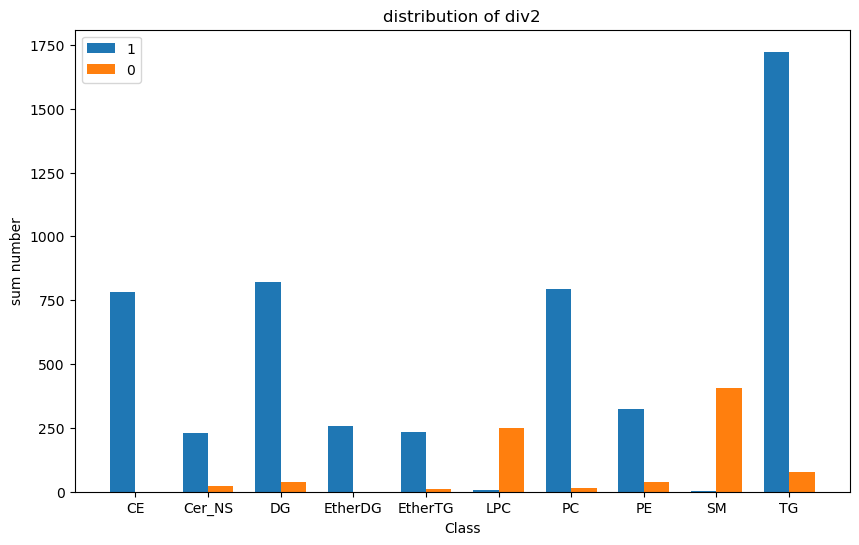

In [17]:
selected_columns = df_pos_data2x[df_pos_data2x['Ontology'].isin(class_list)][['Ontology', 'div2']]

# クラスごとに0と1の出現回数を計算
class_counts = selected_columns.groupby('Ontology')['div2'].value_counts().unstack().fillna(0)

# プロット
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(class_counts))

bar1 = ax.bar(index, class_counts[1], bar_width, label='1')
bar2 = ax.bar([i + bar_width for i in index], class_counts[0], bar_width, label='0')

ax.set_xlabel('Class')
ax.set_ylabel('sum number')
ax.set_title('distribution of div2')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(class_counts.index)
ax.legend()

plt.show()

In [81]:
unique_ontologies = train_ds['Ontology'].unique()
df_pos_data2x_shap_df1 = pd.DataFrame()
df_pos_data2x_shap_df2 = pd.DataFrame()

for ontology in unique_ontologies:
    ontology_data_train = train_ds[train_ds['Ontology'] == ontology]
    ontology_data_test = test_ds[test_ds['Ontology'] == ontology]
    df_pos_data2x_shap_df1 = pd.concat([df_pos_data2x_shap_df1, ontology_data_train])
    df_pos_data2x_shap_df2 = pd.concat([df_pos_data2x_shap_df2, ontology_data_test])

In [82]:
X_train_shap = df_pos_data2x_shap_df1.drop(columns=columns_to_drop).astype(float).values
y_train_shap = df_pos_data2x_shap_df1['Ontology']
X_test_shap = df_pos_data2x_shap_df2.drop(columns=columns_to_drop).astype(float).values
y_test_shap = df_pos_data2x_shap_df2['Ontology']

In [19]:
import shap
explainer = shap.KernelExplainer(model.predict,X_train_shap)

4/4 [==============================] - 0s 7ms/step


In [20]:
shap_values = explainer.shap_values(X_test_shap)

np.save('Data/03-1_model_shap/pos/pos_shapvalues_ex2.npy', shap_values)

  0%|          | 0/100 [00:00<?, ?it/s]

15350/15350 [==============================] - 92s 6ms/step


In [83]:
from matplotlib.colors import ListedColormap

# NumPy配列を読み込む
shap_values = np.load('Data/03-1_model_shap/pos/pos_shapvalues_ex2.npy')

total_shap_values = np.sum([np.abs(sv) for sv in shap_values], axis=0)
mean_shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0)

select_ont = ['TG', 'DG', 'PC', 'CE', 'SM', 'PE', 'EtherDG', 'LPC', 'Cer_NS', 'EtherTG'] #df_pos_data2.Ontologyの上位10クラス
total_shap_values2 = pd.DataFrame(total_shap_values).set_index(y_test_shap.reset_index(drop=False).Ontology).reset_index()
total_shap_values2['Ontology'] = total_shap_values2['Ontology'].apply(lambda x: x if x in select_ont else 'Others')
total_shap_values2 = total_shap_values2.groupby('Ontology').mean()

mean_shap_values2 = pd.DataFrame(mean_shap_values).set_index(y_test_shap.reset_index(drop=False).Ontology).reset_index()
mean_shap_values2['Ontology'] = mean_shap_values2['Ontology'].apply(lambda x: x if x in select_ont else 'Others')
mean_shap_values2 = mean_shap_values2.groupby('Ontology').mean()

feature_names = df_feature['featurename']

# 上位20個の特徴量を抽出
top_features_indices = pd.DataFrame(pd.DataFrame(total_shap_values2).sum(axis=0)).rename(columns={0:'sumvalue'}).sort_values("sumvalue", ascending=False)[:20].reset_index()['index'].tolist()
top_feature_names = feature_names.iloc[top_features_indices]
top_feature_df = pd.DataFrame(mean_shap_values2)[top_features_indices].T
top_feature_df.index = top_feature_names

#カラーマップ
tab20_colors = plt.cm.tab20.colors
selected_colors = [list(color) for color in tab20_colors[:20]]
custom_cmap = ListedColormap(selected_colors, name='custom_tab20')

In [84]:
mean_shap_values2.columns = feature_names
total_shap_values2.columns = feature_names 

excel_file = 'Data/03-1_model_shap/pos/shap_select10_pos.xlsx'
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    pd.DataFrame(mean_shap_values2).transpose().to_excel(writer, sheet_name='Positive shap_mean')
    pd.DataFrame(total_shap_values2).transpose().to_excel(writer, sheet_name='Positive shap_total')

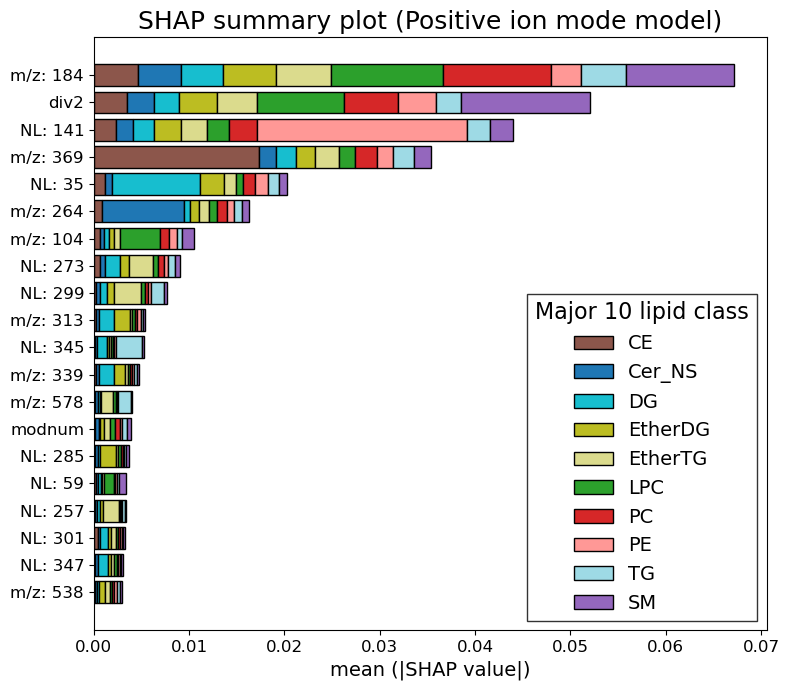

In [85]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

top_feature_df2_POS = top_feature_df.T
cl = plt.cm.tab20.colors
cmap_POS = [cl[10], cl[0], cl[18], cl[16], cl[17], cl[4],  cl[6], cl[7], cl[19], cl[8]]
custom_legend_order = ['CE', 'Cer_NS', 'DG','EtherDG', 'EtherTG', 'LPC',  'PC', 'PE', 'TG', 'SM']
top_feature_df2_POS = top_feature_df2_POS.loc[custom_legend_order]

fig, ax = plt.subplots(figsize=(8, 7))
for i in range(len(top_feature_df2_POS)):
    ax.barh(top_feature_df2_POS.columns, top_feature_df2_POS.iloc[i], left=top_feature_df2_POS.iloc[:i].sum(), color=cmap_POS[i], ec='black', linewidth=1)
plt.title('SHAP summary plot (Positive ion mode model)', fontsize = 18)
plt.xlabel('mean (|SHAP value|)', fontsize = 14)
plt.ylabel('')
plt.tick_params(labelsize=12)
plt.legend(custom_legend_order, title = 'Major 10 lipid class', fontsize=14, title_fontsize=16) #custom_legend_order,
plt.gca().invert_yaxis()
plt.tight_layout()
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black' # edgeの色を変更

plt.savefig('Data/svg/model/shap/pos_shap.svg', format='svg', dpi=300, bbox_inches='tight')

モデルの保存と学習曲線

In [12]:
ls c_final/v1/model/pos_class_model_3

assets/  fingerprint.pb*  keras_metadata.pb*  saved_model.pb*  variables/


In [ ]:
# 描画サイズ 
plt.figure(figsize=(8, 5))

# 学習過程の可視化
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='valid')
plt.xticks(range(0, len(history.epoch)+1, 50))
plt.ylabel('Loss', fontsize=20)  
plt.xlabel('Epochs', fontsize=20)  
plt.title('Learning curves (Positive ion mode NN model)', fontsize=20) 
plt.legend(loc='upper right', fontsize=16) 
plt.savefig('Data/svg/model/learning_curve/pos_learning_curve.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

train/testにおける正答率

In [12]:
y_pred_train = model.predict(X_train)
y_pred_train_max = np.argmax(y_pred_train, axis=1)
_, y_train_acc = np.where(y_train_onehot > 0) 

y_pred_test = model.predict(X_test)
y_pred_test_max = np.argmax(y_pred_test, axis=1)
_, y_test_acc = np.where(y_test_onehot > 0) 


# 正答率
train_accuracy = accuracy_score(y_train_acc, y_pred_train_max)
test_accuracy = accuracy_score(y_test_acc, y_pred_test_max)

print('Neural Network_train :', train_accuracy)
print('Neural Network_test :', test_accuracy)

53/53 [==============================] - 0s 6ms/step
Neural Network_train : 0.9950073964497042
Neural Network_test : 0.9461856889414547


予測結果のまとめ

In [64]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_train_predclass = pd.DataFrame(y_pred_train).rename(columns=replacement_dict_reversed)

df_train_predclass['pred_1class'] = np.vectorize(replacement_dict_reversed.get)(y_pred_train_max)
df_train_predclass['pred_class'] = df_train_predclass.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_train_predclass['pred_number'] = df_train_predclass['pred_class'].apply(lambda x: len(x.split(',')))

df_train_predclass_v = df_train_predclass[['pred_1class','pred_class','pred_number']]
df_copy = df_pos_data2.drop(columns=columns_to_drop).reset_index().rename(columns={'index':'id'})['id'].copy(deep=True)
df_train_predclass_v = df_train_predclass_v.assign(id=df_copy)

df_train_predclass_v['id'] = y_train.index.tolist()
df_train_predclass_v = df_train_predclass_v.set_index('id')


pred1st_train =  len(df_train_predclass_v[y_train_acc == y_pred_train_max]) / len(df_train_predclass)
predcandidate_train = pred1st_train


print('1st pred :', pred1st_train)

print('1st pred num:',len(df_train_predclass_v[y_train_acc == y_pred_train_max]))

print('all num:', len(df_train_predclass))

1st pred : 0.9950073964497042
1st pred num: 5381
all num: 5408


In [13]:
import seaborn as sns

replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}
df_test_predclass = pd.DataFrame(y_pred_test).rename(columns=replacement_dict_reversed)

df_test_predclass['pred_1class'] = np.vectorize(replacement_dict_reversed.get)(y_pred_test_max)
df_test_predclass['pred_class'] = df_test_predclass.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_test_predclass['pred_number'] = df_test_predclass['pred_class'].apply(lambda x: len(x.split(',')))

df_test_predclass_v = df_test_predclass[['pred_1class','pred_class','pred_number']]
df_copy = df_pos_data2.drop(columns=columns_to_drop).reset_index().rename(columns={'index':'id'})['id'].copy(deep=True)
df_test_predclass_v = df_test_predclass_v.assign(id=df_copy)

df_test_predclass_v['id'] = test_d.index.tolist()
df_test_predclass_v = df_test_predclass_v.set_index('id')

df_test_predclass.to_csv('Data/03_model/pos/pos_df_test_predclass.csv')


df_mispred = pd.concat([df_test_predclass_v, test_d[['Ontology']]], axis=1)[y_test_acc != y_pred_test_max]
    
df_mispred['TF'] = df_mispred.apply(base.check_ontology_in_pred_class, axis=1)

pred1st_test =  len(df_test_predclass_v[y_test_acc == y_pred_test_max]) / len(df_test_predclass)
predcandidate_test = (len(df_test_predclass_v[y_test_acc == y_pred_test_max]) + len(df_mispred.query('TF == True'))) / len(df_test_predclass)

print('1st pred :', pred1st_test)
print('candidate :', predcandidate_test)

print('1st pred num:',len(df_test_predclass_v[y_test_acc == y_pred_test_max]))
print('candidate num:',len(df_test_predclass_v[y_test_acc == y_pred_test_max]) + len(df_mispred.query('TF == True')))

print('all num:', len(df_test_predclass))

1st pred : 0.9461856889414547
candidate : 0.9804849201655825
1st pred num: 1600
candidate num: 1658
all num: 1691


In [65]:
df_model_result = pd.DataFrame(data=[len(df_train_predclass_v[y_train_acc == y_pred_train_max]),len(df_train_predclass_v[y_train_acc == y_pred_train_max]) + len(df_mispred.query('TF == True')),len(df_train_predclass), len(df_test_predclass_v[y_test_acc == y_pred_test_max]),len(df_test_predclass_v[y_test_acc == y_pred_test_max]) + len(df_mispred.query('TF == True')),len(df_test_predclass)], \
                               index=['train_1st', 'train_candidate', 'train_number','test_1st', 'test_candidate','test_number'])
df_model_result.to_csv('Data/03_model/pos/df_pos_model_pred_result.csv')

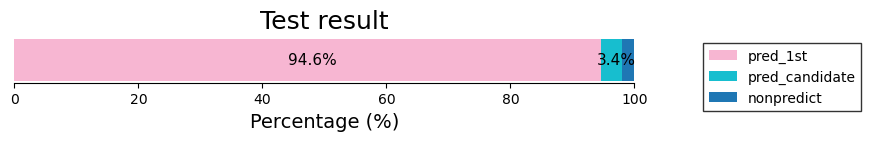

In [46]:
import matplotlib.pyplot as plt

# データの準備
test_pred_1st = round(pred1st_test * 100, 1)
test_pred_candidate = round(predcandidate_test * 100, 1)
percentages = [test_pred_1st, test_pred_candidate-test_pred_1st, 100-test_pred_candidate]
percentages2 = [test_pred_1st, round(test_pred_candidate-test_pred_1st, 1), ]
categories = ["pred_1st", "pred_candidate", "nonpredict"]

fig = plt.figure(figsize=(8, 0.6))  # figsizeを調整して適切なサイズに設定
bar_width = 0.6

# バーの中心位置を計算
bar_centers = [ percentages[0]/2, percentages[0] + percentages[1]/2, percentages[0] + percentages[1] + percentages[2]/2,]
cl = plt.cm.tab20.colors
deep_palette = [cl[18], cl[13], cl[0]]

# 水平な積み上げ棒グラフを描画
bars = plt.barh(1, percentages[0], height=bar_width, color=deep_palette[1], label='pred_1st')
plt.barh(1, percentages[1], left=percentages[0], height=bar_width, color=deep_palette[0], label='pred_candidate')
plt.barh(1, percentages[2], left=percentages[0] + percentages[1], height=bar_width, color=deep_palette[2], label='nonpredict')

# パーセントラベルを描画
for category, center, percentage in zip(categories, bar_centers, percentages2):
    plt.text(center+0.7, 1, f'{percentage}%', ha='center', va='center', fontsize=11, color='black')

# ラベルを設定
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.xlim(0, 100) 
plt.title('Test result', fontsize=18)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('Data/svg/model/result/pos/pos_testresult_percentage.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
df_train = pd.DataFrame(y_train)
df_train['data'] = 'train'

df_test = pd.DataFrame(y_test)
df_test['data'] = 'test'

df_eval= pd.DataFrame(y_eval)
df_eval['data'] = 'eval'

df_3type = pd.concat([df_train, df_test, df_eval], axis=0).reset_index().rename(columns={'index':'id'}).drop('Ontology', axis=1)

pred_df = pd.merge(df_pos_data2[['Metabolitename', 'Ontology']].reset_index().rename(columns={'index':'id'}), df_3type, on='id', how='left')

test_1stpred = df_test_predclass_v[y_test_acc == y_pred_test_max].reset_index().id
test_candidate = df_mispred.query('TF == True').reset_index().rename(columns={'index':'id'}).id
test_false = df_mispred.query('TF == False').reset_index().rename(columns={'index':'id'}).id

pred_df.loc[pred_df['id'].isin(test_1stpred), 'data'] = 'test: 1st pred'
pred_df.loc[pred_df['id'].isin(test_candidate), 'data'] = 'test: candidate'
pred_df.loc[pred_df['id'].isin(test_false), 'data'] = 'test: non predicted'

In [28]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

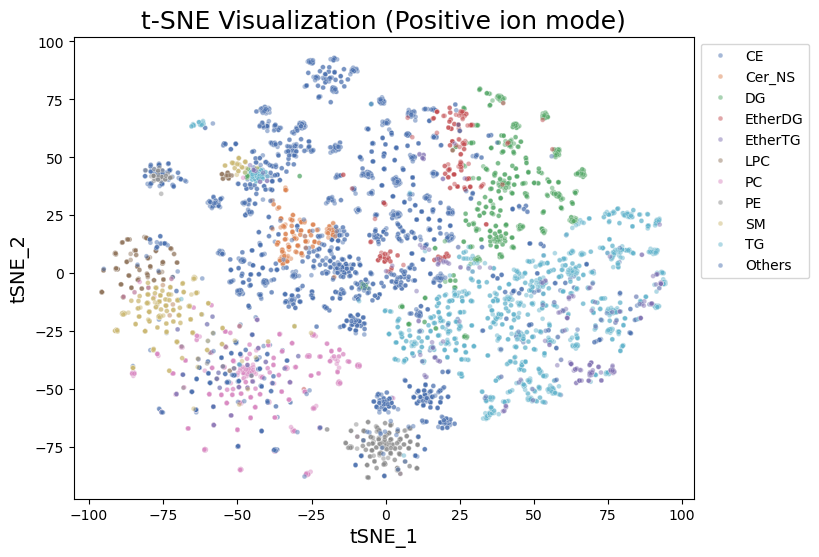

In [30]:
select_ont = ['TG', 'DG', 'PC', 'CE', 'SM', 'PE', 'EtherDG', 'LPC', 'Cer_NS', 'EtherTG']
pred_df['select_ont'] = pred_df['Ontology'].apply(lambda x: x if x in select_ont else 'Others')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=pred_df['select_ont'], palette='deep', s=12, alpha=0.5, hue_order=['CE','Cer_NS', 'DG', 'EtherDG','EtherTG', 'LPC',  'PC', 'PE',  'SM',  'TG', 'Others'])
plt.title('t-SNE Visualization (Positive ion mode)', fontsize = 18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.savefig('Data/svg/model/result/pos/pos_test_tsne_color-by-ontology.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

canopusとの比較用データの準備

In [14]:
df_allexp = pd.concat([df_test_predclass_v, y_test], axis=1)
df_allexp['TF'] = df_allexp.apply(base.check_ontology_in_pred_class, axis=1)
select_ont = pd.read_csv('Data/04_canopus/pos/subclass_ont_select_pos.csv')

In [15]:
df_allexp2 = pd.merge(df_allexp.reset_index(), select_ont, on='Ontology', how='inner').rename(columns={'subclass':'cor_subclass', 'index':'index_ID'})
df_allexp2 = pd.merge(df_allexp2, select_ont, left_on = 'pred_1class', right_on = 'Ontology', how='left').rename(columns={'subclass':'pred_subclass','Ontology_y':'pred_ont'})
df_allexp2.to_csv('Data/04_canopus/pos/df_pos_subclass_pred_ont.csv')

In [16]:
subclasslist = ['Monoradylglycerols',
 'Ceramides',
 'Diradylglycerols',
 'Glycerophosphocholines',
 'Triradylglycerols',
 'Phosphosphingolipids',
 'Glycosphingolipids',
 'Glycerophosphoethanolamines',
 'Glycerophosphoglycerols']

df_pos_subclass_pred = pd.DataFrame(columns=['Subclass', 'Correct_Predictions', 'Incorrect_Predictions', 'Total'])

for i in subclasslist:
    df_allexp2_i = df_allexp2[df_allexp2['cor_subclass'] == i]
    correct_predictions = len(df_allexp2_i[df_allexp2_i['cor_subclass'] == df_allexp2_i['pred_subclass']])
    incorrect_predictions = len(df_allexp2_i) - correct_predictions
    total_samples = len(df_allexp2_i)

    new_row = {'Subclass': i,
               'Correct_Predictions': correct_predictions,
               'Incorrect_Predictions': incorrect_predictions,
               'Total': total_samples}
    
    df_pos_subclass_pred = pd.concat([df_pos_subclass_pred, pd.DataFrame([new_row])], ignore_index=True)
    
df_pos_subclass_pred.to_csv('Data/04_canopus/pos/df_pos_subclass_pred.csv', index=False)